In [2]:
'''
SEIRS-CoV-2 Model Proof-of-Concept Notebook
Author: Eric Renart
Last Update: 08/28/2021
'''

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp, odeint
from matplotlib import pyplot as pp
from sklearn.linear_model import LinearRegression

In [3]:
def ode_function(Y, t, rates, probabilities):
    S, E, A, I, H, ICU, VENT, D, R, VAX = Y
    beta, gamma, gamma_H, gamma_ICU, gamma_VENT, delta, delta_H, delta_ICU, delta_VENT, delta_D, phi, omega = rates
    P_asymptomatic, P_H_from_I, P_ICU_from_H, P_VENT_from_ICU, P_D_from_VENT, P_INIT_VAX = probabilities
    N = S + E + A + I + H + ICU + VENT + R + VAX

    # Calculate inverse probabilities
    P_R_from_I = 1 - P_H_from_I
    P_R_from_H = 1 - P_ICU_from_H
    P_R_from_ICU = 1 - P_VENT_from_ICU
    P_R_from_VENT = 1 - P_D_from_VENT
    P_symptomatic = 1 - P_asymptomatic

    '''
    Differential ODE's
    Assumptions:
    1. Birth and Death rates are equal (LAMBDA = mu)
    2. Everyone is ventilated in ICU before dying (ie. no excess deaths apart from natural deathrate)
    3. People can only get vaccinated when susceptible or recovered
    4. Probabilities do not depend on age (Age-dependence TBI)
    5. Vaccines are 100% effective (effects of VOCs TBI)
    Equations are fully alegibraically expanded for ease of debugging.
    '''

    total_I = I + A # Symptomatics and asymptomatics are both infectious
    total_I_over_N = total_I / N
    dSdt = (omega * R) - (beta * S * total_I_over_N) - (phi * P_INIT_VAX * S)
    dEdt = (beta * S * total_I_over_N) - (delta * P_asymptomatic * E) - (delta * P_symptomatic * E)
    dAdt = (delta * P_asymptomatic * E) - (gamma * A)
    dIdt = (delta * P_symptomatic * E) - (delta_H * P_H_from_I * I) - (gamma * P_R_from_I * I)
    dHdt = (delta_H * P_H_from_I * I) - (delta_ICU * P_ICU_from_H * H) - (gamma_H * P_R_from_H * H)
    dICUdt = (delta_ICU * P_ICU_from_H * H) - (delta_VENT * P_VENT_from_ICU * ICU) - (gamma_ICU * P_R_from_ICU * ICU)
    dVENTdt = (delta_VENT * P_VENT_from_ICU * ICU) - (delta_D * P_D_from_VENT * VENT) - (gamma_VENT * P_R_from_VENT * VENT)
    dDdt = delta_D * P_D_from_VENT * VENT
    dRdt = (gamma * I) + (gamma * A) + (gamma_H * H) + (gamma_ICU * ICU) + (gamma_VENT * VENT) - (omega * R) - (phi * P_INIT_VAX * R)
    dVAXdt = (phi * P_INIT_VAX * S) + (phi * P_INIT_VAX * R)

    return (dSdt, dEdt, dAdt, dIdt, dHdt, dICUdt, dVENTdt, dDdt, dRdt, dVAXdt)


In [4]:
def run(initials, probabilities, rates, length):
    t = np.linspace(0,length,length)
    results_ts = odeint(ode_function, initials, t, args=(probabilities, rates))
    results_df = pd.DataFrame({'t': t, 'Susceptible': results_ts[:,0], 'Exposed': results_ts[:,1], 'Asymptomatic': results_ts[:,2], 'Symptomatic': results_ts[:,3],'Hospitalized': results_ts[:,4], 'ICU': results_ts[:,5], 'Ventilated': results_ts[:,6], 'Dead': results_ts[:,7], 'Recovered': results_ts[:,8], 'Vaccinated': results_ts[:,9]})
    results_df = results_df.astype('int32')
    results_df['Total N'] = results_df.sum(axis=1)
    results_df['Active Cases'] = results_df['Exposed'] + results_df['Asymptomatic'] + results_df['Symptomatic'] + results_df['Hospitalized'] + results_df['ICU'] + results_df['Ventilated']
    results_df['Mild Cases'] = results_df['Asymptomatic'] + results_df['Symptomatic']
    results_df['Total Hospitalized'] = results_df['Hospitalized'] + results_df['ICU'] + results_df['Ventilated']
    results_df['Total ICU'] = results_df['ICU'] + results_df['Ventilated']
    return results_df

In [5]:
# Virus parameters

# R0. TODO: use current R0 from CAN
R0_base = 6.5 # Delta Variant

# Times
t_incubation = 5 # Incubation Period from infection to symptoms if they appear
t_symptomatic_to_hospitalized = 7
t_hospitalized_to_icu = 7
t_icu_to_ventilator = 2
t_ventilator_to_dead = 7
t_mild_asymptomatic_to_recovered = 7
t_hospitalized_to_recovered = 10
t_icu_to_recovered = 15
t_ventilated_to_recovered = 17
t_immunity_loss = 360
vaccination_rate = 0

# Probabilities
p_asymptomatic = 0.35
p_symptomatic_to_hospitalized = 0.15
p_hospitalized_to_icu = 0.20
p_icu_to_ventilator = 0.55
p_ventilator_to_dead = 0.80
vaccine_hesitance = 0.25

# Construct the inputs to model
gamma = 1 / t_mild_asymptomatic_to_recovered
beta = R0_base * gamma

# Calculate rates of state transitions
rates = [beta, gamma, 1/t_hospitalized_to_recovered, 1/t_icu_to_recovered, 1/t_ventilated_to_recovered, 1/t_incubation, 1/t_symptomatic_to_hospitalized, 1/t_hospitalized_to_icu, 1/t_icu_to_ventilator, 1/t_ventilator_to_dead, vaccination_rate, 1/t_immunity_loss]

# Probabilities of state transitions
probabilities = [p_asymptomatic, p_symptomatic_to_hospitalized, p_hospitalized_to_icu, p_icu_to_ventilator, p_ventilator_to_dead, 1-vaccine_hesitance]

In [6]:
# Initial populatiion conditions
S0 = 999999
E0 = 1
A0 = 0
I0 = 0
H0 = 0
ICU0 = 0
VENT0 = 0
D0 = 0
R0 = 0
VAX0 = 0
initials = [S0, E0, A0, I0, H0, ICU0, VENT0, D0, R0, VAX0]

In [7]:
# Run model
sim_length = 360
results = run(initials, rates, probabilities, sim_length)
results

,t,Susceptible,Exposed,Asymptomatic,Symptomatic,Hospitalized,ICU,Ventilated,Dead,Recovered,Vaccinated,Total N,Active Cases,Mild Cases,Total Hospitalized,Total ICU
0,0,999999,1,0,0,0,0,0,0,0,0,1000000,1,0,0,0
1,1,999998,0,0,0,0,0,0,0,0,0,999999,0,0,0,0
2,2,999998,0,0,0,0,0,0,0,0,0,1000000,0,0,0,0
3,3,999998,1,0,0,0,0,0,0,0,0,1000002,1,0,0,0
4,4,999997,1,0,0,0,0,0,0,0,0,1000002,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,355,193291,8615,4068,7555,1476,138,314,31661,948572,0,1196045,22166,11623,1928,452
356,356,194126,8686,4091,7597,1478,138,313,31697,947777,0,1196259,22303,11688,1929,451
357,357,194941,8760,4115,7643,1481,138,311,31733,946993,0,1196472,22448,11758,1930,449
358,358,195735,8838,4141,7691,1484,138,310,31769,946223,0,1196687,22602,11832,1932,448


In [8]:
def plot(results_df, log=False):
    fig, ax = pp.subplots(figsize=(12,8))
    t = results_df['t']
    ax.plot(t, results_df['Susceptible'], label='Susceptible', color='blue')
    ax.plot(t, results_df['Exposed'], label='Exposed', color='yellow')
    ax.plot(t, results_df['Asymptomatic'], label='Asymptomatic', color='pink')
    ax.plot(t, results_df['Symptomatic'], label='Symptomatic', color='red')
    ax.plot(t, results_df['Mild Cases'], label='Total Mild Cases (I+A)', color='salmon', linestyle=':')
    ax.plot(t, results_df['Hospitalized'], label='Hospitalized', color='firebrick')
    ax.plot(t, results_df['ICU'], label='In ICU', color='purple')
    ax.plot(t, results_df['Ventilated'], label='On ventilator', color='hotpink')
    ax.plot(t, results_df['Total Hospitalized'], label='Total Hospitalized (H+ICU+VENT)', color='firebrick', linestyle=':')
    ax.plot(t, results_df['Total ICU'], label='Total in ICU (ICU+VENT)', color='purple', linestyle=':')
    ax.plot(t, results_df['Dead'], label='Dead', color='black')
    ax.plot(t, results_df['Active Cases'], label='Total Active (E+I+A+H+ICU+VENT)', color='red', linestyle=':')
    ax.plot(t, results_df['Total N'], label='Total N', color='gray', linestyle=':') #For debug
    if log:
      ax.set_yscale('log')
    ax.set_xlabel('Day')
    ax.set_title('SEIRS-COV-2 model, N = {}, base R0 = {}'.format(results_df['Total N'].iloc[0], R0_base))
    ax.grid(color='lightgray')
    ax.legend()

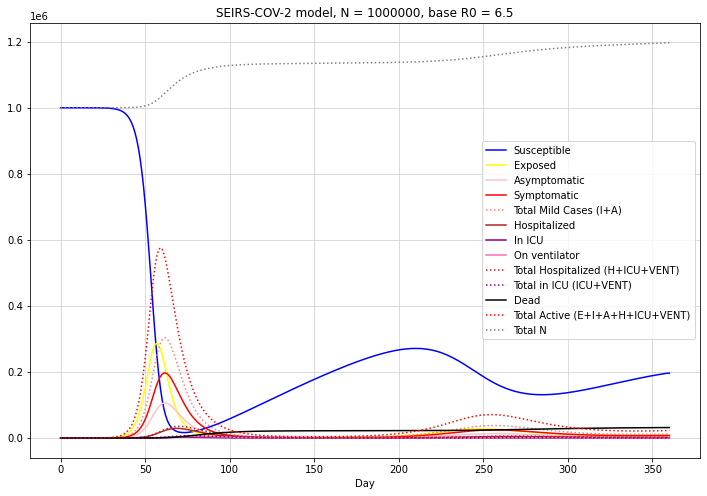

In [9]:
plot(results, log=False)

In [15]:
def summary_stats(results_df):
    max_exposed = results_df['Exposed'].max()
    max_exposed_day = results_df.index[results_df['Exposed'] == max_exposed]
    max_mild = results_df['Mild Cases'].max()
    max_mild_day = results_df.index[results_df['Mild Cases'] == max_mild]
    max_hospitalized = results_df['Total Hospitalized'].max()
    max_hospitalized_day = results_df.index[results_df['Total Hospitalized'] == max_hospitalized]
    max_icu = results_df['Total ICU'].max()
    max_icu_day = results_df.index[results_df['Total ICU'] == max_icu]
    max_ventilated = results_df['Ventilated'].max()
    max_ventilated_day = results_df.index[results_df['Ventilated'] == max_ventilated]
    max_dead = results_df['Dead'].max()
    max_active = results_df['Active Cases'].max()
    max_active_day = results_df[results_df['Active Cases'] == max_active]
    print('Maximum exposed: {} on day {}'.format(max_exposed, max_exposed_day))
    print('Maximum active cases: {} on day {}'.format(max_active, max_active_day))
    print('Maximum infected: {} on day {}'.format(max_mild, max_mild_day))
    print('Maximum hospitalized: {} on day {}'.format(max_hospitalized, max_hospitalized_day))
    print('Maximum in ICU: {} on day {}'.format(max_icu, max_icu_day))
    print('Maximum on ventilator: {} on day {}'.format(max_ventilated, max_ventilated_day))
    print('--- TOTALS ---')
    tail = results_df.tail(1)
    total_infected = tail['Active Cases'] + tail['Dead']
    total_dead = tail['Dead']
    print('Total Infected: {}'.format(total_infected))
    print('Total Dead: {}'.format(total_dead))


In [16]:
summary_stats(results)

Maximum exposed: 286612 on day Int64Index([57], dtype='int64')
Maximum active cases: 575948 on day      t  Susceptible  Exposed  Asymptomatic  Symptomatic  Hospitalized   ICU  \
59  59       151033   269382        100279       186233         17903  1135   

    Ventilated  Dead  Recovered  Vaccinated  Total N  Active Cases  \
59        1016   540     303973           0  1031553        575948   

    Mild Cases  Total Hospitalized  Total ICU  
59      286512               20054       2151  
Maximum infected: 303229 on day Int64Index([62], dtype='int64')
Maximum hospitalized: 35409 on day Int64Index([70], dtype='int64')
Maximum in ICU: 7296 on day Int64Index([77], dtype='int64')
Maximum on ventilator: 4922 on day Int64Index([79], dtype='int64')
--- TOTALS ---
Total Infected: 359    54570
dtype: int32
Total Dead: 359    31804
Name: Dead, dtype: int32
